# Standard Sparse AutoEncoder

In [1]:
from StandardSAE import StandardTrainer

activation_dim, dict_size = 512, 512 * 64
device = 'cuda:0'
trainer = StandardTrainer(
    activation_dim=512,
    dict_size=dict_size,
    lr=1e-4,
    l1_penalty=5e-2,
    warmup_steps=100, # lr warmup period at start of training and after each resample
    device=device,
    resample_steps=100, # how often to resample neurons,
)

In [2]:
import os
import torch
from pathlib import Path
from StandardSAE import AutoEncoder

# resolve paths
output_dir = Path('outputs')
output_dir.mkdir(parents=True, exist_ok=True)
check_path = output_dir / 'params.pth'

# check save
ae = trainer.ae
torch.save(ae.state_dict(), check_path)

# check load
loaded_ae = AutoEncoder.from_pretrained(check_path)
loaded_ae

AutoEncoder(
  (encoder): Linear(in_features=512, out_features=32768, bias=False)
  (decoder): Linear(in_features=32768, out_features=512, bias=False)
)

In [3]:
# encode and decode
activations = torch.randn(4, activation_dim, device=device)
reconstructed_activations, features = ae(activations, output_features=True)
reconstructed_activations.shape, features.shape

(torch.Size([4, 512]), torch.Size([4, 32768]))

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# setup
infos = {}
log_step = 5
total_steps = 2000

# train
pbar = tqdm(total=total_steps)
for step in range(1, total_steps + 1):
    pbar.update(1)
    act = torch.randn(32, 512).to(device)
    trainer.update(step, act)
    if step % log_step == 0:
        with torch.no_grad():
            infos[step] = trainer.loss(act, logging=True)[3]


  0%|          | 0/2000 [00:00<?, ?it/s]

{'loss': 66.91676330566406, 'l2_loss': 19.10369300842285, 'mse_loss': 367.3069152832031, 'sparsity_loss': 956.2613525390625}


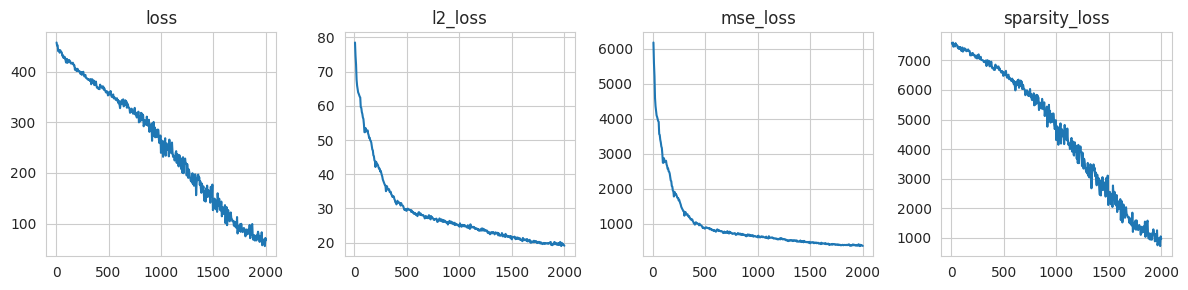

In [5]:
# show loss log
sns.set_style('whitegrid')
steps = sorted(list(infos.keys()))
names = list(infos[steps[0]].keys())
fig, axes = plt.subplots(1, len(names), figsize=(12, 3))
for i in range(len(names)):
    name = names[i]
    sns.lineplot(x=steps, y=[infos[step][name] for step in steps], ax=axes[i])
    axes[i].set_title(name)
plt.tight_layout()
os.makedirs('assets', exist_ok=True)
plt.savefig('assets/loss.png')
print(infos[2000])